In [51]:
import torch
from torch import nn, optim
from torchvision import models, transforms
import sys
sys.path.insert(1, '../05/')
from going_modular import data_setup, engine
from torchinfo import summary
from timeit import default_timer as timer
from helper_functions import plot_loss_curves
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
import pandas as pd

In [3]:
train_dir = 'data/pizza_steak_sushi/train'
test_dir = 'data/pizza_steak_sushi/test'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Data Preparation

In [5]:
weights = models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
pretrained_transforms = weights.transforms()
pretrained_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_transforms,
    batch_size = 32
)

### Load pretrained model and make it ready

In [14]:
model = models.efficientnet_b0(weights = weights, progress=True).to(device)

In [16]:
summary(model=model, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params','trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [17]:
# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
# Customize classifier layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

In [19]:
summary(model=model, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params','trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

### Train model

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start = timer()
results = engine.train(
    model, train_loader, test_loader, loss_fn, optimizer, device, epochs = 5
)
end = timer()

print(f'Model trained for: {end-start:.3f} seconds.')

  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_p

Epoch: 1 | Train loss: 1.0965 | Train acc: 0.3867 | Test loss: 0.8828 | Test acc: 0.5587


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 2 | Train loss: 0.9248 | Train acc: 0.6133 | Test loss: 0.7969 | Test acc: 0.7945


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 3 | Train loss: 0.7773 | Train acc: 0.7539 | Test loss: 0.6776 | Test acc: 0.8655


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 4 | Train loss: 0.7247 | Train acc: 0.7578 | Test loss: 0.6972 | Test acc: 0.7841


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 5 | Train loss: 0.6193 | Train acc: 0.7969 | Test loss: 0.6500 | Test acc: 0.8665
Model trained for: 421.738 seconds.


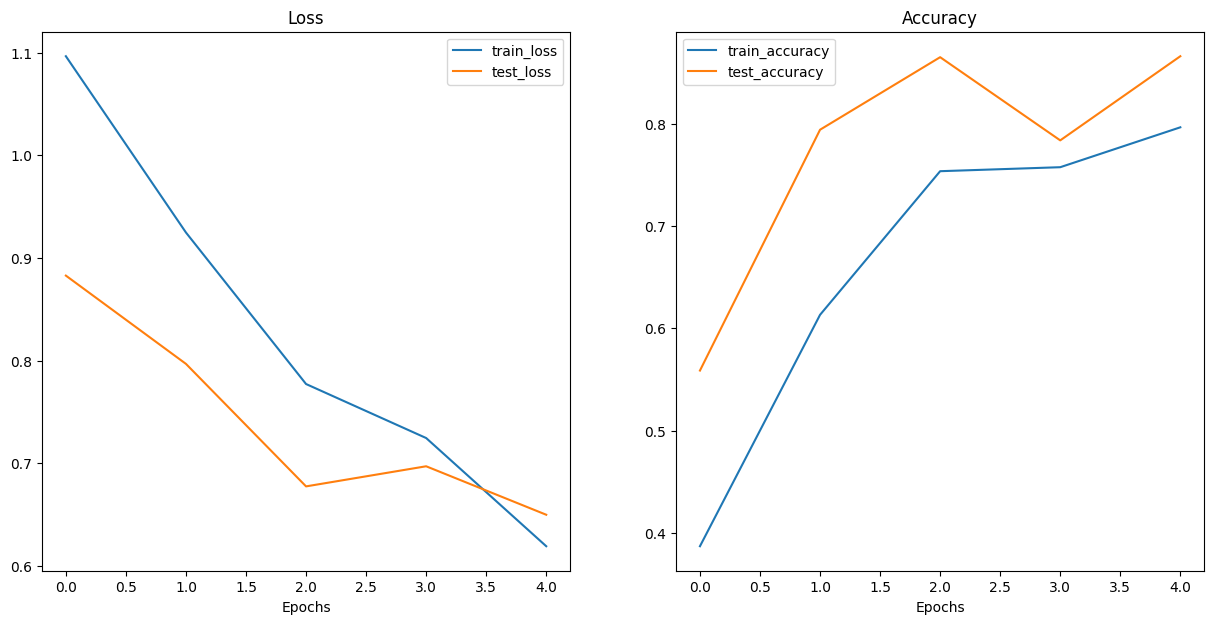

In [24]:
plot_loss_curves(results)

In [49]:
### Get "most wrong" predictions

def make_predictions(test_paths, model, transform, class_names, device):
    predictions = []
    for path in tqdm(test_paths):
        pred_dict = {}
        pred_dict['img_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name
        img = Image.open(path)
        transformed_img = transform(img).unsqueeze(dim=0) # (1, 3, 224, 224)
        model.eval()
        with torch.inference_mode():
            y_logits = model(transformed_img.to(device))
            y_prob = torch.softmax(y_logits, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            pred_class = class_names[y_pred.cpu()]

            pred_dict['pred_prob'] = y_prob.unsqueeze(0).max().cpu().item()
            pred_dict['pred_class'] = pred_class
        pred_dict['correct'] = class_name == pred_class
        predictions.append(pred_dict)

    return predictions

test_paths = list(Path(test_dir).glob('*/*.jpg'))
test_labels = [path.parent.stem for path in test_paths]

predictions = make_predictions(test_paths, model, pretrained_transforms, class_names, device)

100%|██████████| 75/75 [00:14<00:00,  5.00it/s]


In [53]:
predictions_df = pd.DataFrame(predictions)
top_5_most_wrong = predictions_df.sort_values(by=['correct', 'pred_prob'], ascending=[True, False]).head()
top_5_most_wrong

,img_path,class_name,pred_prob,pred_class,correct
37,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.549378,steak,False
53,data/pizza_steak_sushi/test/pizza/344397.jpg,pizza,0.499032,sushi,False
44,data/pizza_steak_sushi/test/sushi/2276986.jpg,sushi,0.460735,steak,False
24,data/pizza_steak_sushi/test/sushi/1245193.jpg,sushi,0.457386,pizza,False
60,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.455156,steak,False
